In [7]:
import sys
print(sys.executable)

c:\Users\VAIBHAV VARSHNEY\Desktop\Resume Analyzer\.venv\Scripts\python.exe


In [8]:
import os
print(os.getcwd())


c:\Users\VAIBHAV VARSHNEY\Desktop\Resume Analyzer\Notebooks


In [11]:
import pandas as pd
import json

# Load JSON Lines
data_path = '../DATA/master_resumes.jsonl'
# Each line is a JSON object
records = [json.loads(line) for line in open(data_path, 'r', encoding='utf-8')]

raw_df = pd.DataFrame(records)
print("Rows:", len(raw_df))
raw_df.head(3)

Rows: 4817


,personal_info,experience,education,skills,projects,certifications,achievements,workshops,publications,teaching_experience,internships
0,"{'name': 'Unknown', 'email': 'Unknown', 'phone...","[{'company': 'Fresher', 'company_info': {'indu...","[{'degree': {'level': 'ME', 'field': 'Computer...",{'technical': {'programming_languages': [{'nam...,"[{'name': 'Unknown', 'description': 'Unknown',...",,NaN,NaN,NaN,NaN,NaN
1,"{'name': 'Unknown', 'email': 'Unknown', 'phone...","[{'company': 'Delta Controls, Dubai FZCO', 'co...","[{'degree': {'level': 'B.E', 'field': 'Electro...",{'technical': {'project_management': [{'name':...,"[{'name': 'FGP/WPMP', 'description': 'Led syst...",,NaN,NaN,NaN,NaN,NaN
2,"{'name': 'Not Provided', 'email': 'Not Provide...","[{'company': 'Parkar Consulting and Labs', 'co...","[{'degree': {'level': 'B.E.', 'field': 'Not Pr...",{'technical': {'programming_languages': [{'nam...,"[{'name': 'FPGA Implementation', 'description'...",,NaN,NaN,NaN,NaN,NaN


In [12]:
print(raw_df.columns)
print('INFO')
print(raw_df.info())
print('MISSING VALUES')
print(raw_df.isnull().sum())


Index(['personal_info', 'experience', 'education', 'skills', 'projects',
       'certifications', 'achievements', 'workshops', 'publications',
       'teaching_experience', 'internships'],
      dtype='object')
INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4817 entries, 0 to 4816
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   personal_info        4816 non-null   object
 1   experience           4817 non-null   object
 2   education            4817 non-null   object
 3   skills               4817 non-null   object
 4   projects             4806 non-null   object
 5   certifications       4817 non-null   object
 6   achievements         4 non-null      object
 7   workshops            4 non-null      object
 8   publications         3 non-null      object
 9   teaching_experience  1 non-null      object
 10  internships          2 non-null      object
dtypes: object(11)
memory usage: 414.1+ 

In [13]:

# Helper: safe getters
def safe_get(d, *keys):
    try:
        for k in keys:
            d = d[k]
        return d
    except Exception:
        return None

# 2) Extract name and email from personal_info (robust)
def extract_from_personal(info, key):
    if not isinstance(info, dict):
        return "Not Available"
    # common direct keys
    if key in info and info[key]:
        val = info[key]
        if isinstance(val, (list, tuple)) and len(val) > 0:
            return str(val[0]).strip()
        return str(val).strip()
    # try alternative keys
    alt_keys = {
        'name': ['fullname', 'full_name', 'displayname'],
        'email': ['e-mail', 'mail']
    }
    for alt in alt_keys.get(key, []):
        if alt in info and info[alt]:
            return str(info[alt]).strip()
    # fallback: search nested dict values for email pattern / likely name
    # quick pass: scan string values
    import re
    email_re = re.compile(r"[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}")
    for v in info.values():
        if isinstance(v, str) and v.strip():
            if key == 'email' and email_re.search(v):
                return email_re.search(v).group(0)
            if key == 'name' and len(v.split()) <= 5 and not email_re.search(v):
                return v.strip()
        if isinstance(v, (list, tuple)):
            for item in v:
                if isinstance(item, str):
                    if key == 'email' and email_re.search(item):
                        return email_re.search(item).group(0)
                    if key == 'name' and len(item.split()) <= 5 and not email_re.search(item):
                        return item.strip()
    return "Not Available"

raw_df['name'] = raw_df['personal_info'].apply(lambda x: extract_from_personal(x, 'name') if 'personal_info' in raw_df.columns else "Not Available")
raw_df['email'] = raw_df['personal_info'].apply(lambda x: extract_from_personal(x, 'email') if 'personal_info' in raw_df.columns else "Not Available")

# 3) Extract education (take the first education entry's degree level + field if present)
def extract_education(edu):
    try:
        if isinstance(edu, list) and len(edu)>0 and isinstance(edu[0], dict):
            deg = edu[0].get('degree', {})
            if isinstance(deg, dict):
                level = deg.get('level') or deg.get('name') or ''
                field = deg.get('field') or ''
                if level or field:
                    return (str(level).strip() + (" in " + str(field).strip() if field else "")).strip()
            # fallback: look for 'institution' or 'college' or simple text
            inst = edu[0].get('institution') or edu[0].get('college') or edu[0].get('school')
            if inst:
                return str(inst)
        # if it's a string
        if isinstance(edu, str) and edu.strip():
            return edu.strip()
    except Exception:
        pass
    return "Not Available"

raw_df['education_clean'] = raw_df['education'].apply(extract_education)

# 4) Extract skills: walk nested dicts under 'skills' and collect 'name'/'skill' text or keys/values
def extract_skills(sk_dict):
    try:
        all_skills = []
        if isinstance(sk_dict, dict):
            # common pattern: {'technical': {'programming_languages': [{'name': 'Python'}, ...], ...}, 'languages': ...}
            def collect(x):
                if isinstance(x, dict):
                    # if dict has 'name' key and it's a string -> take it
                    if 'name' in x and isinstance(x['name'], str):
                        all_skills.append(x['name'].strip())
                    else:
                        for v in x.values():
                            collect(v)
                elif isinstance(x, list):
                    for it in x:
                        collect(it)
                elif isinstance(x, str):
                    all_skills.append(x.strip())
            collect(sk_dict)
        # dedupe and join
        all_skills = [s for s in pd.unique(all_skills) if s and s.lower() not in ('none','n/a','unknown')]
        return ', '.join(all_skills) if all_skills else "Not Available"
    except Exception:
        return "Not Available"

raw_df['skills_clean'] = raw_df['skills'].apply(extract_skills)

# 5) Extract project names (collect 'name' from each project entry)
def extract_projects(proj_list):
    try:
        if isinstance(proj_list, list):
            names = []
            for p in proj_list:
                if isinstance(p, dict):
                    if 'name' in p and p['name']:
                        names.append(str(p['name']).strip())
                    else:
                        # maybe title
                        if 'title' in p and p['title']:
                            names.append(str(p['title']).strip())
                elif isinstance(p, str):
                    names.append(p.strip())
            names = [n for n in pd.unique(names) if n and n.lower() not in ('none','n/a','unknown')]
            return ', '.join(names) if names else "Not Available"
        if isinstance(proj_list, str) and proj_list.strip():
            return proj_list.strip()
    except Exception:
        pass
    return "Not Available"

raw_df['projects_clean'] = raw_df['projects'].apply(extract_projects)

# 6) Extract top experience entry (title + company) or fallback text
def extract_experience(exp_list):
    try:
        if isinstance(exp_list, list) and len(exp_list)>0:
            e0 = exp_list[0]
            if isinstance(e0, dict):
                title = e0.get('title') or e0.get('designation') or ''
                company = e0.get('company') or e0.get('organization') or ''
                if title or company:
                    s = (str(title).strip() + (" at " + str(company).strip() if company else "")).strip()
                    return s if s else "Not Available"
            # fallback to text length
            if isinstance(e0, str) and e0.strip():
                return e0.strip()
        if isinstance(exp_list, str) and exp_list.strip():
            return exp_list.strip()
    except Exception:
        pass
    return "Not Available"

raw_df['experience_clean'] = raw_df['experience'].apply(extract_experience)

# 7) Build final dataframe with selected columns and rename
final_df = raw_df[['name','email','education_clean','skills_clean','experience_clean','projects_clean']].copy()
final_df.rename(columns={
    'education_clean': 'education',
    'skills_clean': 'skills',
    'experience_clean': 'experience',
    'projects_clean': 'projects'
}, inplace=True)

# 8) Drop rows with missing core skills (optional) - keep for now but report counts
print("\nCounts before dropping missing skills/education:")
print("Total records:", len(final_df))
print("Rows with skills = Not Available:", (final_df['skills']=='Not Available').sum())
print("Rows with education = Not Available:", (final_df['education']=='Not Available').sum())

# 9) Save cleaned CSV
final_df.to_csv("../DATA/resume_dataset_clean.csv", index=False)
print("\nSaved cleaned dataset to ../DATA/resume_dataset_clean.csv")

# 10) Show preview
print("\nPreview of cleaned data (first 8 rows):")
display(final_df.head(8))

# 11) Basic stats
print("\nUnique skills (sample):")
# quick sample of top skill tokens (not perfect tokenization, just a glance)
skills_series = final_df['skills'].replace("Not Available", pd.NA).dropna().str.split(', ')
top_skills = pd.Series([s for sub in skills_series for s in sub]).value_counts().head(15)
print(top_skills)


C:\Users\VAIBHAV VARSHNEY\AppData\Local\Temp\ipykernel_31200\3814422559.py:94: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  all_skills = [s for s in pd.unique(all_skills) if s and s.lower() not in ('none','n/a','unknown')]
C:\Users\VAIBHAV VARSHNEY\AppData\Local\Temp\ipykernel_31200\3814422559.py:116: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = [n for n in pd.unique(names) if n and n.lower() not in ('none','n/a','unknown')]



Counts before dropping missing skills/education:
Total records: 4817
Rows with skills = Not Available: 12
Rows with education = Not Available: 4

Saved cleaned dataset to ../DATA/resume_dataset_clean.csv

Preview of cleaned data (first 8 rows):


,name,email,education,skills,experience,projects
0,Unknown,Unknown,ME in Computer Engineering,"Python, C++, C, Tensorflow, Numpy, MySQL",Python Developer at Fresher,Not Available
1,Unknown,Unknown,B.E in Electronics,"Project Execution, Quality Management, Budget ...","Operations Manager at Delta Controls, Dubai FZCO","FGP/WPMP, Grain LNG RTLF, AMC TO HPM Migration..."
2,Not Provided,Not Provided,B.E. in Not Provided,"C, SQL, PL/SQL, JAVA, JAVAEE, Javascript, HTML...",DevOps Engineer at Parkar Consulting and Labs,"FPGA Implementation, Sorting Robot, RFID Based..."
3,Unknown,Unknown,B.E in Electronics,"Project Execution, Quality Management, Budget ...","Operations Manager at Delta Controls, Dubai FZCO","FGP/WPMP, Grain LNG RTLF, AMC TO HPM Migration..."
4,Not Available,Not Available,Bachelor of Engineering in Computer,"Python, Django, MySQL",Python Developer at Atos Syntel,Not Available
5,Not Available,Not Available,Diploma in Computer Science,Python,Python Developer at Cybage Software Pvt. Ltd,Not Available
6,Not Available,Not Available,B.E in Computer Science and Engineering,"C, C++, J2EE, Spring, Hibernate, My SQL, Postg...",Java Developer at Inouvelle Ventures Private L...,Stock Management System
7,Unknown,Unknown,High School in Science,"Java, Spring, Hibernate, MySQL",Java Developer at Kunal IT Services Pvt Ltd,Not Available



Unique skills (sample):
English         4644
Python          2793
JavaScript      1780
AWS             1698
Java            1597
Google Cloud    1589
React           1519
Azure           1484
MySQL           1453
MongoDB         1429
Redis           1410
Node.js         1398
Oracle          1397
Ruby            1384
C++             1384
Name: count, dtype: int64


In [14]:
fallback_path = "../DATA/resume_dataset_clean.csv"

if not os.path.exists(fallback_path):
    raise FileNotFoundError(f"Could not find cleaned file at {fallback_path}. "
                            "Run the flattening cell first or adjust this path if saved elsewhere.")

final_df = pd.read_csv(fallback_path)
print("✅ Reloaded cleaned dataset successfully.")
print("Rows:", len(final_df))
print("Columns:", final_df.columns.tolist())

# Ensure data directory exists in the current working directory
os.makedirs("data", exist_ok=True)

# Fix dedup warnings by replacing pd.unique
def split_tokens(s):
    if pd.isna(s) or not isinstance(s, str) or s.strip() == "" or s == "Not Available":
        return []
    return [tok.strip() for tok in s.split(',') if tok.strip()]

def join_tokens_unique(tokens):
    if not tokens:
        return "Not Available"
    unique = list(dict.fromkeys([t for t in tokens if t and t.lower() not in ('none','n/a','unknown')]))
    return ', '.join(unique) if unique else "Not Available"

# Dedupe skill and project lists (optional)
final_df['skills'] = final_df['skills'].apply(lambda s: join_tokens_unique(split_tokens(s)))
final_df['projects'] = final_df['projects'].apply(lambda s: join_tokens_unique(split_tokens(s)))

# Save full cleaned dataset (no rows dropped)
full_path = "data/resume_dataset_clean_full.csv"
final_df.to_csv(full_path, index=False)
print(f"✅ Saved full cleaned dataset to {full_path}")

# Drop rows missing skills (tiny number)
total = len(final_df)
final_model_df = final_df[final_df['skills'] != "Not Available"].copy()
dropped = total - len(final_model_df)
print(f"\nDropped {dropped} rows with missing skills. Remaining: {len(final_model_df)}")

# Save modeling dataset
model_path = "data/resume_dataset_clean.csv"
final_model_df.to_csv(model_path, index=False)
print(f"✅ Saved modeling dataset to {model_path}")

# Quick insight into skills
skills_series = final_model_df['skills'].replace("Not Available", pd.NA).dropna().str.split(', ')
top_skills = pd.Series([s for sub in skills_series for s in sub]).value_counts().head(15)
print("\nTop 15 skills (sample):")
print(top_skills)

# Show a small preview
print("\nPreview of cleaned data:")
display(final_model_df.head(5))

✅ Reloaded cleaned dataset successfully.
Rows: 4817
Columns: ['name', 'email', 'education', 'skills', 'experience', 'projects']
✅ Saved full cleaned dataset to data/resume_dataset_clean_full.csv

Dropped 12 rows with missing skills. Remaining: 4805
✅ Saved modeling dataset to data/resume_dataset_clean.csv

Top 15 skills (sample):
English         4644
Python          2793
JavaScript      1780
AWS             1698
Java            1597
Google Cloud    1589
React           1519
Azure           1484
MySQL           1453
MongoDB         1429
Redis           1410
Node.js         1398
Oracle          1397
Ruby            1384
C++             1384
Name: count, dtype: int64

Preview of cleaned data:


,name,email,education,skills,experience,projects
0,Unknown,Unknown,ME in Computer Engineering,"Python, C++, C, Tensorflow, Numpy, MySQL",Python Developer at Fresher,Not Available
1,Unknown,Unknown,B.E in Electronics,"Project Execution, Quality Management, Budget ...","Operations Manager at Delta Controls, Dubai FZCO","FGP/WPMP, Grain LNG RTLF, AMC TO HPM Migration..."
2,Not Provided,Not Provided,B.E. in Not Provided,"C, SQL, PL/SQL, JAVA, JAVAEE, Javascript, HTML...",DevOps Engineer at Parkar Consulting and Labs,"FPGA Implementation, Sorting Robot, RFID Based..."
3,Unknown,Unknown,B.E in Electronics,"Project Execution, Quality Management, Budget ...","Operations Manager at Delta Controls, Dubai FZCO","FGP/WPMP, Grain LNG RTLF, AMC TO HPM Migration..."
4,Not Available,Not Available,Bachelor of Engineering in Computer,"Python, Django, MySQL",Python Developer at Atos Syntel,Not Available


In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Set style
plt.style.use('ggplot')

# Reload modeling dataset (if needed)
df = pd.read_csv("../DATA/resume_dataset_clean.csv")

print("✅ Dataset loaded for EDA")
print("Rows:", len(df))
print("Columns:", df.columns.tolist())
df.head(3)


✅ Dataset loaded for EDA
Rows: 4817
Columns: ['name', 'email', 'education', 'skills', 'experience', 'projects']


,name,email,education,skills,experience,projects
0,Unknown,Unknown,ME in Computer Engineering,"Python, C++, C, Tensorflow, Numpy, MySQL",Python Developer at Fresher,Not Available
1,Unknown,Unknown,B.E in Electronics,"Project Execution, Quality Management, Budget ...","Operations Manager at Delta Controls, Dubai FZCO","FGP/WPMP, Grain LNG RTLF, AMC TO HPM Migration..."
2,Not Provided,Not Provided,B.E. in Not Provided,"C, SQL, PL/SQL, JAVA, JAVAEE, Javascript, HTML...",DevOps Engineer at Parkar Consulting and Labs,"FPGA Implementation, Sorting Robot, RFID Based..."


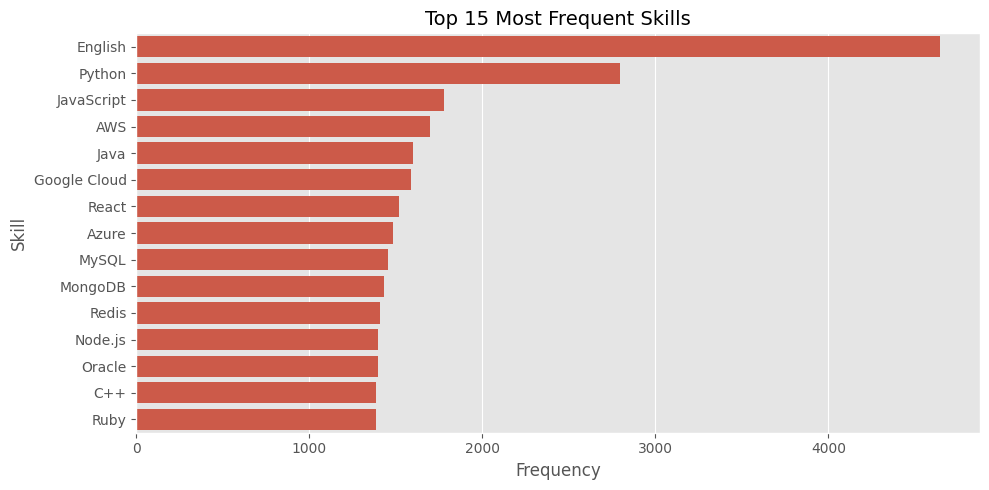

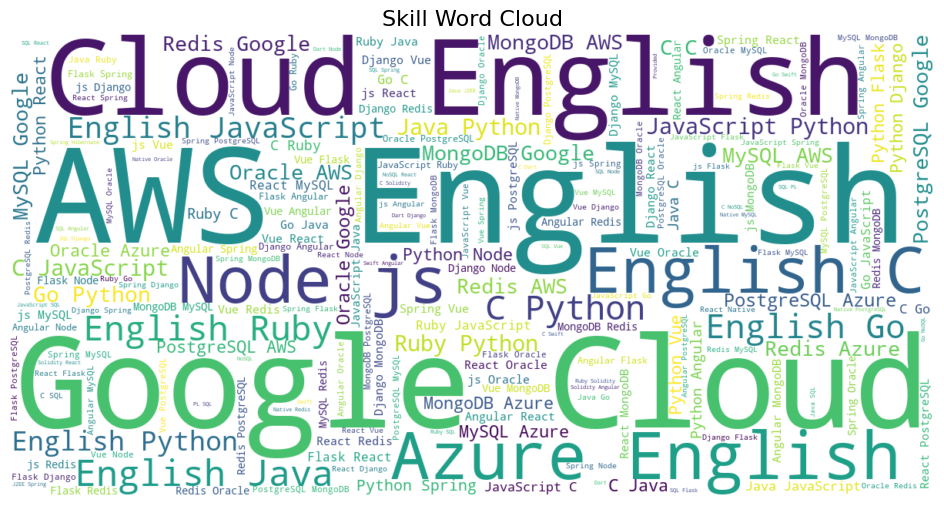

In [24]:
from collections import Counter

# Convert skills column into a list of all individual skills
all_skills = []
df['skills'].dropna().apply(lambda x: [all_skills.append(s.strip()) for s in str(x).split(',') if s.strip()])

# Count frequency of each skill
skill_counts = Counter(all_skills)
top_skills = dict(skill_counts.most_common(15))

# --- Bar Plot for Top Skills ---
plt.figure(figsize=(10,5))
sns.barplot(x=list(top_skills.values()), y=list(top_skills.keys()))
plt.title("Top 15 Most Frequent Skills", fontsize=14)
plt.xlabel("Frequency")
plt.ylabel("Skill")
plt.tight_layout()
plt.show()

# --- Word Cloud for All Skills ---
all_skills_text = ' '.join(all_skills)

wordcloud = WordCloud(width=1200, height=600, background_color='white', colormap='viridis').generate(all_skills_text)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Skill Word Cloud", fontsize=16)
plt.show()


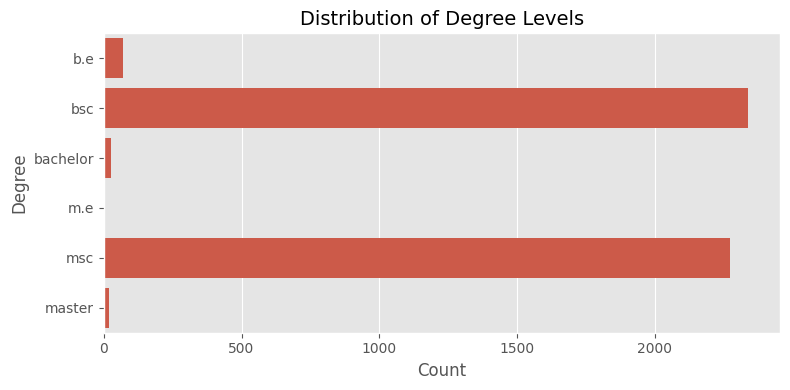

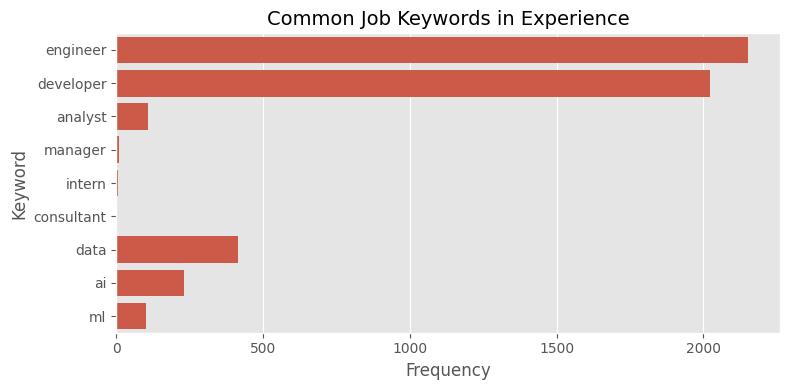

In [25]:
# --- EDUCATION ANALYSIS ---

# Clean and simplify education field
edu_clean = df['education'].dropna().str.lower()

# Extract degree level keywords
degree_keywords = ['b.tech', 'b.e', 'bsc', 'bachelor', 'm.tech', 'm.e', 'msc', 'master', 'phd', 'mba']
degree_counts = {deg: edu_clean.str.contains(deg).sum() for deg in degree_keywords}
degree_counts = {k:v for k,v in degree_counts.items() if v > 0}

# Plot
plt.figure(figsize=(8,4))
sns.barplot(x=list(degree_counts.values()), y=list(degree_counts.keys()))
plt.title("Distribution of Degree Levels", fontsize=14)
plt.xlabel("Count")
plt.ylabel("Degree")
plt.tight_layout()
plt.show()

# --- EXPERIENCE ANALYSIS ---

# Extract words from 'experience' column
exp_words = []
df['experience'].dropna().apply(lambda x: [exp_words.append(w.strip()) for w in str(x).split() if w.strip().isalpha()])

# Filter for relevant job keywords
keywords = ['engineer', 'developer', 'analyst', 'manager', 'intern', 'consultant', 'data', 'ai', 'ml']
exp_counts = {word: sum([1 for w in exp_words if word in w.lower()]) for word in keywords}

plt.figure(figsize=(8,4))
sns.barplot(x=list(exp_counts.values()), y=list(exp_counts.keys()))
plt.title("Common Job Keywords in Experience", fontsize=14)
plt.xlabel("Frequency")
plt.ylabel("Keyword")
plt.tight_layout()
plt.show()


In [26]:
data = [
    ["Data Analyst", "Python, SQL, Excel, PowerBI, Tableau, Statistics", "Analytics"],
    ["Data Scientist", "Python, Pandas, NumPy, Scikit-learn, Deep Learning, Statistics, Visualization", "Data Science"],
    ["ML Engineer", "Python, TensorFlow, Keras, PyTorch, Scikit-learn, AWS, MLOps", "Machine Learning"],
    ["AI Engineer", "Python, NLP, Transformers, LangChain, LLMs, Deep Learning", "Artificial Intelligence"],
    ["Data Engineer", "Python, SQL, Spark, Hadoop, AWS, ETL, Airflow", "Data Engineering"],
    ["Business Analyst", "Excel, PowerBI, SQL, Communication, Requirements Analysis", "Business Intelligence"],
    ["Software Engineer", "Python, Java, C++, Git, REST APIs, Data Structures", "Software Development"],
    ["Cloud Engineer", "AWS, Docker, Kubernetes, CI/CD, Linux, Terraform", "Cloud Computing"],
    ["DevOps Engineer", "AWS, Jenkins, Docker, CI/CD, GitHub Actions, Monitoring", "DevOps"],
    ["Product Manager", "Communication, Agile, Product Roadmap, Jira, Business Analysis", "Product Management"]
]

# Create DataFrame
job_roles = pd.DataFrame(data, columns=["Role", "Required_Skills", "Domain"])

# Save it in the data folder
os.makedirs("data", exist_ok=True)
job_roles.to_csv("../DATA/job_roles.csv", index=False)

print("✅ job_roles.csv created successfully and saved in data/ folder.")
print(job_roles)

✅ job_roles.csv created successfully and saved in data/ folder.
                Role                                    Required_Skills  \
0       Data Analyst   Python, SQL, Excel, PowerBI, Tableau, Statistics   
1     Data Scientist  Python, Pandas, NumPy, Scikit-learn, Deep Lear...   
2        ML Engineer  Python, TensorFlow, Keras, PyTorch, Scikit-lea...   
3        AI Engineer  Python, NLP, Transformers, LangChain, LLMs, De...   
4      Data Engineer      Python, SQL, Spark, Hadoop, AWS, ETL, Airflow   
5   Business Analyst  Excel, PowerBI, SQL, Communication, Requiremen...   
6  Software Engineer  Python, Java, C++, Git, REST APIs, Data Struct...   
7     Cloud Engineer   AWS, Docker, Kubernetes, CI/CD, Linux, Terraform   
8    DevOps Engineer  AWS, Jenkins, Docker, CI/CD, GitHub Actions, M...   
9    Product Manager  Communication, Agile, Product Roadmap, Jira, B...   

                    Domain  
0                Analytics  
1             Data Science  
2         Machine Learn

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Load datasets
resumes = pd.read_csv("../DATA/resume_dataset_clean.csv")
job_roles = pd.read_csv("../DATA/job_roles.csv")

print("✅ Data Loaded")
print("Resumes:", resumes.shape)
print("Job Roles:", job_roles.shape)

# Combine text fields from resumes into a single "profile text"
resumes['profile_text'] = resumes[['skills', 'projects', 'education', 'experience']].fillna('').agg(' '.join, axis=1)

# TF-IDF vectorizer (fit on combined data from resumes + job roles)
vectorizer = TfidfVectorizer(stop_words='english')

# Combine resume profiles and job role skill descriptions for joint vocabulary
combined_corpus = list(resumes['profile_text'].values) + list(job_roles['Required_Skills'].values)
tfidf_matrix = vectorizer.fit_transform(combined_corpus)

# Split the TF-IDF matrix
resume_vecs = tfidf_matrix[:len(resumes)]
role_vecs = tfidf_matrix[len(resumes):]

# Compute cosine similarity between each resume and each job role
similarity_matrix = cosine_similarity(resume_vecs, role_vecs)

# Assign the best-matching job role to each resume
best_match_indices = np.argmax(similarity_matrix, axis=1)
resumes['predicted_role'] = job_roles.iloc[best_match_indices]['Role'].values
resumes['similarity_score'] = np.max(similarity_matrix, axis=1)

# Preview
resumes[['name', 'skills', 'predicted_role', 'similarity_score']].head(100)


✅ Data Loaded
Resumes: (4817, 6)
Job Roles: (10, 3)


,name,skills,predicted_role,similarity_score
0,Unknown,"Python, C++, C, Tensorflow, Numpy, MySQL",ML Engineer,0.218169
1,Unknown,"Project Execution, Quality Management, Budget ...",DevOps Engineer,0.049605
2,Not Provided,"C, SQL, PL/SQL, JAVA, JAVAEE, Javascript, HTML...",Data Engineer,0.059818
3,Unknown,"Project Execution, Quality Management, Budget ...",DevOps Engineer,0.049605
4,Not Available,"Python, Django, MySQL",Data Analyst,0.019768
...,...,...,...,...
95,Unknown,"Python, C, C++, Java, HTML, Django, MySQL, Eng...",Software Engineer,0.025150
96,Not Available,"C, C++, Java, Android, MS Access, SQL, Oracle",Software Engineer,0.056115
97,Unknown,"Java, J2EE, Swift, HTML, Shell Script, MySQL, ...",DevOps Engineer,0.057453
98,Not Provided,"Python, Shell Scripting, Not Provided, AWS, Azure",Data Engineer,0.014965


Top predicted roles (counts):
predicted_role
Data Analyst         1747
Software Engineer    1473
Data Engineer        1020
AI Engineer           300
Cloud Engineer        113
ML Engineer           112
DevOps Engineer        25
Product Manager        21
Business Analyst        6
Name: count, dtype: int64

Similarity score summary:
count    4817.000000
mean        0.045848
std         0.062621
min         0.000000
25%         0.009885
50%         0.019768
75%         0.048227
max         0.321974
Name: similarity_score, dtype: float64


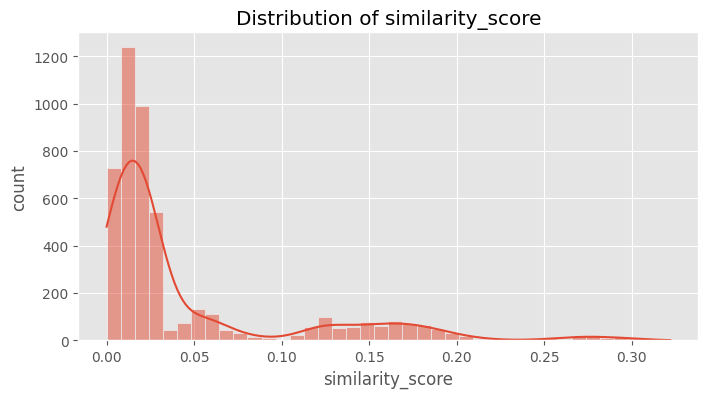


Mean similarity score per predicted role (top 20):
predicted_role
AI Engineer          0.195120
ML Engineer          0.175296
Business Analyst     0.171236
Cloud Engineer       0.160868
Product Manager      0.106555
DevOps Engineer      0.094051
Software Engineer    0.040896
Data Engineer        0.028706
Data Analyst         0.016809
Name: similarity_score, dtype: float64


In [29]:
role_counts = resumes['predicted_role'].value_counts()
print("Top predicted roles (counts):")
print(role_counts.head(20))

# Similarity statistics
sim = resumes['similarity_score']
print("\nSimilarity score summary:")
print(sim.describe())

# Histogram of similarity scores
plt.figure(figsize=(8,4))
sns.histplot(sim, bins=40, kde=True)
plt.title("Distribution of similarity_score")
plt.xlabel("similarity_score")
plt.ylabel("count")
plt.show()

# Mean similarity per role (helps see which roles are matched with higher confidence)
mean_sim_role = resumes.groupby('predicted_role')['similarity_score'].mean().sort_values(ascending=False)
print("\nMean similarity score per predicted role (top 20):")
print(mean_sim_role.head(20))

In [30]:
# B: Flag confident vs low-confidence predictions and sample examples
def conf_label(s):
    if s >= 0.6:
        return "high"
    if s < 0.4:
        return "low"
    return "medium"

resumes['confidence'] = resumes['similarity_score'].apply(conf_label)

print("Confidence counts:")
print(resumes['confidence'].value_counts())

# Show some high confidence examples (top 8)
print("\nHigh-confidence examples (top 8):")
display(resumes[resumes['confidence']=='high'][['name','skills','predicted_role','similarity_score']].head(8))

# Show some low-confidence examples (top 8)
print("\nLow-confidence examples (top 8):")
display(resumes[resumes['confidence']=='low'][['name','skills','predicted_role','similarity_score']].head(8))

# Save samples for manual review
resumes[resumes['confidence']=='low'][['name','skills','predicted_role','similarity_score']].head(200).to_csv("data/low_confidence_samples.csv", index=False)
print("\nSaved up to 200 low-confidence samples to data/low_confidence_samples.csv for manual review.")

Confidence counts:
confidence
low    4817
Name: count, dtype: int64

High-confidence examples (top 8):


,name,skills,predicted_role,similarity_score



Low-confidence examples (top 8):


,name,skills,predicted_role,similarity_score
0,Unknown,"Python, C++, C, Tensorflow, Numpy, MySQL",ML Engineer,0.218169
1,Unknown,"Project Execution, Quality Management, Budget ...",DevOps Engineer,0.049605
2,Not Provided,"C, SQL, PL/SQL, JAVA, JAVAEE, Javascript, HTML...",Data Engineer,0.059818
3,Unknown,"Project Execution, Quality Management, Budget ...",DevOps Engineer,0.049605
4,Not Available,"Python, Django, MySQL",Data Analyst,0.019768
5,Not Available,Python,Data Analyst,0.021605
6,Not Available,"C, C++, J2EE, Spring, Hibernate, My SQL, Postg...",Data Analyst,0.038179
7,Unknown,"Java, Spring, Hibernate, MySQL",Software Engineer,0.027916



Saved up to 200 low-confidence samples to data/low_confidence_samples.csv for manual review.


In [32]:
import re

# Define rough keyword mapping from experience/job titles to roles
role_keywords = {
    'Data Analyst': ['analyst', 'data analyst'],
    'Data Scientist': ['data scientist','scientist'],
    'ML Engineer': ['ml engineer', 'machine learning engineer', 'ml engineer', 'ml'],
    'AI Engineer': ['ai engineer','artificial intelligence'],
    'Data Engineer': ['data engineer','etl','spark','hadoop'],
    'Software Engineer': ['software engineer','developer','software developer','frontend','backend'],
    'Cloud Engineer': ['cloud engineer','aws','azure','gcp','google cloud'],
    'DevOps Engineer': ['devops','ci/cd','kubernetes','jenkins'],
    'Product Manager': ['product manager','pm']
}

def infer_role_from_experience(text):
    if not isinstance(text, str):
        return None
    txt = text.lower()
    for role, keys in role_keywords.items():
        for k in keys:
            if k in txt:
                return role
    return None

# Infer pseudo labels
resumes['pseudo_label'] = resumes['experience'].apply(infer_role_from_experience)

# Keep rows where pseudo label was found
eval_df = resumes[resumes['pseudo_label'].notna()].copy()
print("✅ Rows with pseudo-labels (approx. ground truth):", len(eval_df))

# Compare predicted vs pseudo label
eval_df['match'] = eval_df['predicted_role'] == eval_df['pseudo_label']
rough_accuracy = eval_df['match'].mean()

print(f"\nRough pseudo-label accuracy (noisy heuristic): {rough_accuracy:.3f}")
print("\nConfusion table (sample):")
display(pd.crosstab(eval_df['pseudo_label'], eval_df['predicted_role']).iloc[:10,:10])

# Save for manual inspection
eval_df[['name','skills','experience','predicted_role','pseudo_label','similarity_score']].to_csv(
    "../DATA/pseudo_eval_table.csv", index=False
)
print("\nSaved pseudo_eval_table.csv to data/ for manual inspection.")


✅ Rows with pseudo-labels (approx. ground truth): 3101

Rough pseudo-label accuracy (noisy heuristic): 0.300

Confusion table (sample):


predicted_role,AI Engineer,Business Analyst,Cloud Engineer,Data Analyst,Data Engineer,DevOps Engineer,ML Engineer,Product Manager,Software Engineer
pseudo_label,,,,,,,,,
AI Engineer,0,0,0,45,22,1,0,0,32
Cloud Engineer,2,0,0,4,79,0,0,0,26
Data Analyst,0,0,0,49,22,0,0,7,36
Data Engineer,0,0,0,1,1,0,0,0,101
Data Scientist,0,0,0,0,1,1,3,1,99
DevOps Engineer,0,0,100,3,88,7,0,1,40
ML Engineer,100,0,0,0,0,0,106,0,0
Product Manager,0,0,0,2,1,0,0,0,0
Software Engineer,0,6,12,905,406,9,3,12,767



Saved pseudo_eval_table.csv to data/ for manual inspection.


In [34]:
from sentence_transformers import SentenceTransformer, util


# 2) Load data (model will operate on 'profile_text' if present or create it)
resumes = pd.read_csv("../DATA/resume_dataset_clean.csv")
job_roles = pd.read_csv("../DATA/job_roles.csv")

# Ensure profile_text exists (combine fields)
resumes['profile_text'] = resumes[['skills', 'projects', 'education', 'experience']].fillna('').agg(' '.join, axis=1)

print("Resumes:", resumes.shape)
print("Job roles:", job_roles.shape)

# 3) Load SentenceTransformer model
# Model choice: 'all-MiniLM-L6-v2' is small, fast, and gives good semantic similarity.
model_name = "all-MiniLM-L6-v2"
print(f"Loading SentenceTransformer model '{model_name}' (this may take a few seconds)...")
model = SentenceTransformer(model_name)

# 4) Encode resumes and job role skill descriptions
# Encode in batches to avoid memory spikes
resume_texts = resumes['profile_text'].astype(str).tolist()
role_texts = job_roles['Required_Skills'].astype(str).tolist()

resume_emb = model.encode(resume_texts, batch_size=64, show_progress_bar=True, convert_to_tensor=True)
role_emb = model.encode(role_texts, batch_size=16, show_progress_bar=True, convert_to_tensor=True)

# 5) Compute cosine similarity (using sentence_transformers util for speed)
cosine_sim_matrix = util.cos_sim(resume_emb, role_emb)  # shape: (n_resumes, n_roles)

# 6) For each resume, find best role index and similarity score
best_idx = np.argmax(cosine_sim_matrix.cpu().numpy(), axis=1)
best_scores = np.max(cosine_sim_matrix.cpu().numpy(), axis=1)

resumes['predicted_role_semantic'] = job_roles.iloc[best_idx]['Role'].values
resumes['similarity_score_semantic'] = best_scores

# 7) Quick diagnostics
print("\nTop predicted roles (semantic) - counts:")
print(resumes['predicted_role_semantic'].value_counts().head(20))

print("\nSimilarity score (semantic) summary:")
print(pd.Series(resumes['similarity_score_semantic']).describe())

# Show a few examples (high and low)
top_high = resumes.sort_values('similarity_score_semantic', ascending=False).head(8)[['name','skills','predicted_role_semantic','similarity_score_semantic']]
top_low = resumes.sort_values('similarity_score_semantic', ascending=True).head(8)[['name','skills','predicted_role_semantic','similarity_score_semantic']]

print("\nTop high-confidence semantic matches (sample):")
display(top_high)

print("\nTop low-confidence semantic matches (sample):")
display(top_low)

# 8) Re-run pseudo-label evaluation (noisy heuristic) to compare
# (reuse the same infer_role_from_experience function logic if present; otherwise define minimal)
def infer_role_from_experience(text):
    if not isinstance(text, str):
        return None
    txt = text.lower()
    role_keywords = {
        'Data Analyst': ['analyst', 'data analyst'],
        'Data Scientist': ['data scientist','scientist'],
        'ML Engineer': ['ml engineer', 'machine learning engineer', 'ml engineer', 'ml'],
        'AI Engineer': ['ai engineer','artificial intelligence'],
        'Data Engineer': ['data engineer','etl','spark','hadoop'],
        'Software Engineer': ['software engineer','developer','software developer','frontend','backend'],
        'Cloud Engineer': ['cloud engineer','aws','azure','gcp','google cloud'],
        'DevOps Engineer': ['devops','ci/cd','kubernetes','jenkins'],
        'Product Manager': ['product manager','pm'],
        'Business Analyst': ['business analyst','business analytics','business intelligence']
    }
    for role, keys in role_keywords.items():
        for k in keys:
            if k in txt:
                return role
    return None

resumes['pseudo_label'] = resumes['experience'].apply(infer_role_from_experience)
eval_df = resumes[resumes['pseudo_label'].notna()].copy()
eval_df['match_semantic'] = eval_df['predicted_role_semantic'] == eval_df['pseudo_label']
semantic_accuracy = eval_df['match_semantic'].mean()
print(f"\nRows with pseudo-labels: {len(eval_df)}")
print(f"Rough pseudo-label accuracy (semantic embeddings): {semantic_accuracy:.3f}")

# 9) Save updated predictions
os.makedirs("data", exist_ok=True)
resumes.to_csv("data/resume_predictions_semantic.csv", index=False)
print("\nSaved full predictions to data/resume_predictions_semantic.csv")

# 10) Suggested confidence thresholds for semantic scores (empirical guidance)
print("\nSuggested thresholds (empirical):")
print("- high confidence: similarity >= 0.60")
print("- medium confidence: 0.40 <= similarity < 0.60")
print("- low confidence: similarity < 0.40")

# 11) Add a simple confidence label column
def conf_label(s):
    if s >= 0.60:
        return "high"
    if s < 0.40:
        return "low"
    return "medium"
resumes['confidence_semantic'] = resumes['similarity_score_semantic'].apply(conf_label)

# Summary counts
print("\nConfidence distribution (semantic):")
print(resumes['confidence_semantic'].value_counts())

# Show a few high confidence semantic matches for manual inspection
display(resumes[resumes['confidence_semantic']=='high'][['name','skills','predicted_role_semantic','similarity_score_semantic']].head(10))

Resumes: (4817, 7)
Job roles: (10, 3)
Loading SentenceTransformer model 'all-MiniLM-L6-v2' (this may take a few seconds)...


Batches: 100%|██████████| 1/1 [00:00<00:00, 20.64it/s]


Top predicted roles (semantic) - counts:
predicted_role_semantic
Software Engineer    1915
ML Engineer          1368
Data Engineer        1133
Product Manager       179
AI Engineer           105
Business Analyst       76
Data Analyst           16
Cloud Engineer         16
DevOps Engineer         9
Name: count, dtype: int64

Similarity score (semantic) summary:
count    4817.000000
mean        0.556380
std         0.061136
min         0.199686
25%         0.518826
50%         0.560527
75%         0.599421
max         0.735770
Name: similarity_score_semantic, dtype: float64

Top high-confidence semantic matches (sample):


,name,skills,predicted_role_semantic,similarity_score_semantic
1958,Eric Le,"Python, Flask, MySQL, Redis, AWS, English",Data Engineer,0.735770
4016,Melissa Patterson,"Python, C#, SQL, Flask, Node.js, MySQL, Postgr...",Data Engineer,0.702925
1974,Steven Mcgee,"Go, Python, Spring, Flask, PostgreSQL, MySQL, ...",Data Engineer,0.700653
2192,Eric Washington,"Go, Ruby, Python, Flask, React, Vue, MongoDB, ...",ML Engineer,0.695847
4209,Kevin Becker,"Python, NoSQL, Django, Vue, PostgreSQL, AWS, E...",Data Engineer,0.693353
4559,Isabel Williams,"Go, Python, Vue, Spring, Flask, PostgreSQL, Mo...",Data Engineer,0.693266
311,Brandy Melendez,"C++, Go, Java, Python, Angular, Flask, React, ...",Software Engineer,0.692684
4068,Sandra Harrison,"Python, SQL, Django, Vue, PostgreSQL, MongoDB,...",Data Engineer,0.692268



Top low-confidence semantic matches (sample):


,name,skills,predicted_role_semantic,similarity_score_semantic
86,Unknown,Not Available,DevOps Engineer,0.199686
41,Not Provided,Not Available,DevOps Engineer,0.199686
55,Not Provided,Not Provided,Business Analyst,0.219184
172,Not Available,Not Available,Product Manager,0.246867
162,Not Available,Not Available,Product Manager,0.246867
163,Not Available,Not Available,Product Manager,0.246867
167,Not Provided,Not Provided,DevOps Engineer,0.251837
59,Newcomer Indian Advocate,"Windows, Word processing software, English, Hi...",Product Manager,0.279252



Rows with pseudo-labels: 3101
Rough pseudo-label accuracy (semantic embeddings): 0.471

Saved full predictions to data/resume_predictions_semantic.csv

Suggested thresholds (empirical):
- high confidence: similarity >= 0.60
- medium confidence: 0.40 <= similarity < 0.60
- low confidence: similarity < 0.40

Confidence distribution (semantic):
confidence_semantic
medium    3554
high      1195
low         68
Name: count, dtype: int64


,name,skills,predicted_role_semantic,similarity_score_semantic
12,Fahed,"Python, R Studio, Machine Learning, Data Visua...",Data Analyst,0.646505
15,Fahed,"Python, R Studio, Machine Learning, Data Visua...",Data Analyst,0.646505
20,Artem Sliusarenko,"Python, JavaScript, Java, PyTorch, FastAPI, Re...",ML Engineer,0.621834
45,Fahed,"Python, R Studio, Machine Learning, Data Visua...",Data Analyst,0.646505
53,Artem Sliusarenko,"Python, JavaScript, Java, PyTorch, FastAPI, Re...",ML Engineer,0.621834
68,Not Provided,"Python, C++, C, Tensorflow, Numpy, MySQL, Not ...",ML Engineer,0.614759
71,Unknown,"SQL, Bizagi, MS Visio, Indigo Studio, HPQC, Wa...",Product Manager,0.600334
72,Artem Sliusarenko,"Python, JavaScript, Java, PyTorch, FastAPI, Re...",ML Engineer,0.621834
81,Artem Sliusarenko,"Python, JavaScript, Java, PyTorch, FastAPI, Re...",ML Engineer,0.621834
120,Unknown,"Python, CSS, HTML, MySQL, Django, web services...",Data Engineer,0.600137
